# AM 207 Pset 4
# Spencer Hallyburton

## Collaborator: Salvador Barragan

In [27]:
%matplotlib inline

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import time
from tqdm import tnrange, tqdm_notebook


# Problem 1: Optimization via Descent

Given this loss function for a point (x,y):
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
We need to implement methods to determine our parameters that minimze the loss function over a set of data.

In [29]:
my_data = np.genfromtxt('HW3_data.csv', delimiter=',')
print('Data Shape:', my_data.shape)

Data Shape: (2, 16000)


In [30]:
# Set up functions
from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, LAMBDA):
    T1 =  .000045*LAMBDA[1]**2 * Y 
    T2 = -.000098*LAMBDA[0]**2 * X
    T3 =  .003926*LAMBDA[0] * X * np.exp( (Y**2 - X**2) * (LAMBDA[0]**2 + LAMBDA[1]**2) )
    return np.sum(T1 + T2 + T3)

def make_3d_plot(xfinal, yfinal, zfinal, history, loss, X, Y):
    L1s = np.linspace(xfinal - 10 , xfinal + 10, 40)
    L2s = np.linspace(yfinal - 10 , yfinal + 10, 40)
    L1, L2 = np.meshgrid(L1s, L1s)
    zs = np.array([error(X, Y, LAMBDA) 
                   for LAMBDA in zip(np.ravel(L1), np.ravel(L2))])
    Z = zs.reshape(L1.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    off = -10
    ax.plot_surface(L1, L2, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(L1, L2, Z, 20, alpha=0.5, offset=off, stride=30)
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Loss Function')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in history], [t[1] for t in history], loss , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in history], [t[1] for t in history], off , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    plt.show()
    
def gd_plot(X, Y, LAMBDA, loss, history):
    if not isinstance(loss, list):
        loss = [loss]
    make_3d_plot(LAMBDA[0], LAMBDA[1], loss[-1], history, loss, X, Y)
    

In [59]:
# Implementing Gradient Descent:
def grad_fun(x, y, LAM):
    A = .000045
    B = -.000098
    C = .003926
    EXPONENT = np.exp((y**2-x**2) * (LAM[0]**2 + LAM[1]**2))
    dLd1 = 2*B*LAM[0]*x + C*x*EXPONENT + C*LAM[0]*x*((y**2-x**2)*2*LAM[0])*EXPONENT
    dLd2 = 2*A*LAM[1]*y + C*LAM[0]*x*((y**2-x**2)*2*LAM[1])*EXPONENT
    
    return [np.sum(dLd1), np.sum(dLd2)]
    
    
def gradient_descent(x, y, LAM_init, step=0.001, maxsteps=0, precision=0.00001):
    costs = []
    m = y.size # number of data points
    LAM = LAM_init
    LAM_true = [2.05384, 0]
    history = [] # to store all thetas
    counter = 0
    oldcost = 0
    currcost = error(x, y, LAM)
    counter+=1
    time_iter = 0
    while abs(currcost - oldcost) > precision:
        #np.linalg.norm(np.array(LAM) - LAM_true) / np.linalg.norm(LAM_true) > precision:
        t0 = time.time()
        oldcost=currcost
        gradient = np.asarray(grad_fun(x, y, LAM))
        
        LAM = LAM - step * gradient  # update
        t1 = time.time()
        time_iter += (t1 - t0)

        history.append(LAM)
        
        currcost = error(x, y, LAM)
        costs.append(currcost)
        
        if counter % 10000 == 0: print('COST @ %i = %.4f' % (counter, currcost))
        counter+=1

        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, counter, time_iter/counter

In [83]:
def sgd_minibatch(x, y, LAM, batchsize=1, step=0.001, maxsteps=0, maxepochs=0, precision=0.0001):
    m = y.size # number of data points
    costs = []
    history = []
    grads = []
    costsum = 0
    costsum2 = 0
    counter = 0
    currcost = 0
    oldcost = 0
    ep_cost = []
    i = 0
    time_iter = 0
    
    # Shuffle the data
    neworder = np.random.permutation(m)
    xdata_shuf = x[neworder]     
    ydata_shuf = y[neworder]
    
    epoch = 0; 
    while 1:
    #np.linalg.norm(np.array(LAM) - LAM_true) / np.linalg.norm(LAM_true) > precision:
        # Get next batch:
        last_idx = min(m, (i+1)*batchsize)
        xvals = np.asarray(xdata_shuf[i:last_idx])
        yvals = np.asarray(ydata_shuf[i:last_idx])

        # Get the current cost
        oldcost=currcost
        currcost = error(xvals, yvals, LAM)
        costsum += currcost
        costs.append(currcost)
        
        # Append the last lambda:
        history.append(LAM)

        # Compute gradient
        t0 = time.time()
        gradient = np.asarray(grad_fun(xvals, yvals, LAM))
        gradient = gradient * np.sqrt(m)/batchsize
        grads.append(gradient)
        
        # Update Lambda
        LAM = LAM - step * gradient  # update
        t1 = time.time()
        time_iter += t1-t0
        
        # Check if reached the end and need new epoch
        i+=batchsize
        counter+=1
        if i>=m: #reached one past the end
            epoch+=1
            # Shuffle the data
            neworder = np.random.permutation(m)
            xdata_shuf = x[neworder]     
            ydata_shuf = y[neworder] 
            ep_cost.append(costsum/i)
            costsum = 0
            i=0

        # Check if max steps reached
        if maxsteps:
            if counter == maxsteps:
                print('Max Steps Reached')
                break
        
        # Check if max epochs reached
        if maxepochs:
            if epoch == maxepochs:
                print('Max Epochs Reached')
                break
                        
    return history, costs, counter, time_iter/counter, epoch, ep_cost, grads


### Test out algorithms using different initial conditions and the same learning rate

In [84]:
LAM_init = np.array([ [-2.47865, 0], [-3, 0], [-5, 0], [-10, 0] ] )
step = 0.1
precision = 1e-5
maxsteps = 5000

In [85]:
# Gradient Descent:
historyGD = []
costsGD = []
counterGD = []
time_iterGD = []
    
# Run loop over all initial conditions
for i, LAM in zip(tnrange(len(LAM_init)), LAM_init):
    print('Initial Lambda:', LAM)
    history, costs, counter, time_iter = gradient_descent(my_data[0,:], my_data[1,:], LAM, 
                                                               maxsteps=maxsteps, step=step, precision=precision)
    historyGD.append(history)
    costsGD.append(costs)
    counterGD.append(counter)
    time_iterGD.append(time_iter)
    print('Steps Taken:',counter)
    print('Final Lambda:', historyGD[i][-1])
    print('Gradient at Final Lambda:', grad_fun(my_data[0,:], my_data[1,:], historyGD[i][-1]), '\n')
    

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

Initial Lambda: [-2.47865  0.     ]
Steps Taken: 2
Final Lambda: [-2.47865127  0.        ]
Gradient at Final Lambda: [1.7081469088473314e-05, 0.0] 

Initial Lambda: [-3.  0.]
Steps Taken: 37
Final Lambda: [-5.35875137  0.        ]
Gradient at Final Lambda: [0.0077839379655726404, 0.0] 

Initial Lambda: [-5.  0.]
Steps Taken: 24
Final Lambda: [-5.35869531  0.        ]
Gradient at Final Lambda: [0.0078809794227123753, 0.0] 

Initial Lambda: [-10.   0.]
Steps Taken: 42
Final Lambda: [-5.36798423  0.        ]
Gradient at Final Lambda: [-0.0081911149669060546, 0.0] 




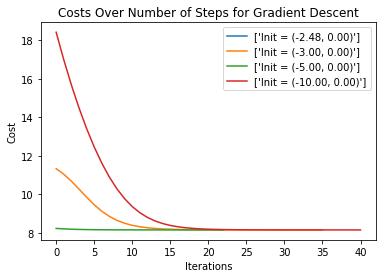

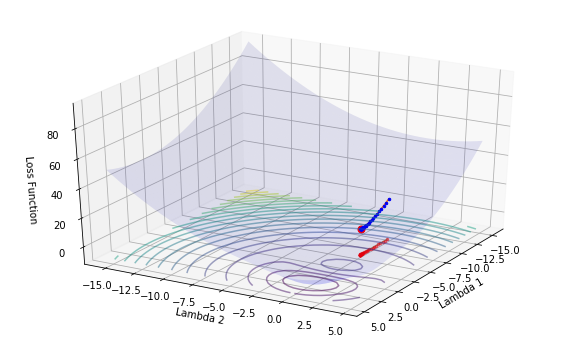

In [86]:
for cost, LAM in zip(costsGD, LAM_init):
    plt.plot(cost, label=['Init = (%.2f, %.2f)'%(LAM[0], LAM[1])])
plt.title('Costs Over Number of Steps for Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Make three-D plot for one of the iterations
gd_plot(my_data[0,:], my_data[1,:], historyGD[3][-1], costsGD[3], historyGD[3])

Based on the above plot of the gradient descent algorithm on different initial conditions, we can see that the first initial condition remains in a local minimum for many iterations before finally jumping out of that one and ending up in a different local minimum. We can see the the other initial conditions converge faster towards the second local minimum. 

We know from previous exercises that this convergence is not into the global minimum. The local minimum here is into the point (-5.36324322, 0). The cost of this point is around 8. We know that the global minimum of this function is (2.05384, 0) with a cost function of nearly -9 from our previous exercises.

If we evaluate the gradient at the point (-5.36324322, 0), we get that it is:

In [87]:
print('Gradient:', np.asarray(grad_fun(my_data[0,:], my_data[1,:], [-5.36324322, 0])))

Gradient: [  1.04513543e-05   0.00000000e+00]


This is very near zero, so we are not surprised that the function converges to this local minimum. 

### Now let's try SGD:

In [88]:
# Stochastic Gradient Descent:
historySGD = []
costsSGD = []
counterSGD = []
time_iterSGD = []
ep_costSGD =[]
batchsize = 20
step = 0.01
# Run loop over all initial conditions
for i, LAM in zip(tnrange(len(LAM_init)), LAM_init):
    print('Initial Lambda:', LAM)
    
    history, costs, counter, time_iter, epoch, ep_cost, grads = sgd_minibatch(my_data[0,:], my_data[1,:], LAM, 
                                                   batchsize, maxepochs=100, precision=precision, step=step)
    ep_costSGD.append(ep_cost)
    historySGD.append(history)
    costsSGD.append(costs)
    counterSGD.append(counter)
    time_iterSGD.append(time_iter)
    print('Final Lambda:', historyGD[i][-1])
    print('Gradient at Final Lambda:', grad_fun(my_data[0,:], my_data[1,:], historySGD[i][-1]), '\n')

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

Initial Lambda: [-2.47865  0.     ]
Max Epochs Reached
Final Lambda: [-2.47865127  0.        ]
Gradient at Final Lambda: [-1.5018809308188497e-10, 0.0] 

Initial Lambda: [-3.  0.]
Max Epochs Reached
Final Lambda: [-5.35875137  0.        ]
Gradient at Final Lambda: [-2.3343525723529268e-10, 0.0] 

Initial Lambda: [-5.  0.]
Max Epochs Reached
Final Lambda: [-5.35869531  0.        ]
Gradient at Final Lambda: [-6461187.8911116123, 0.0] 

Initial Lambda: [-10.   0.]
Max Epochs Reached
Final Lambda: [-5.36798423  0.        ]
Gradient at Final Lambda: [-924947746.02502441, 0.0] 




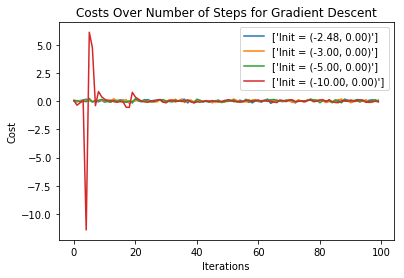

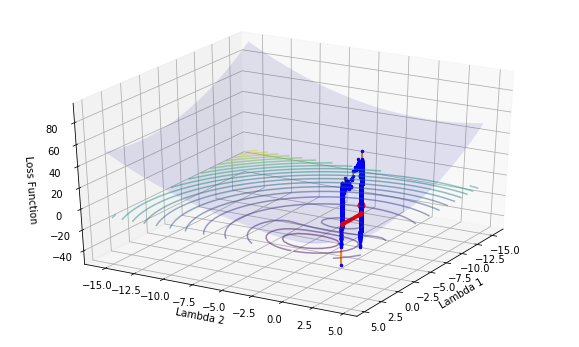

In [73]:
for ep_cost, LAM in zip(ep_costSGD, LAM_init):
    plt.plot(ep_cost, label=['Init = (%.2f, %.2f)'%(LAM[0], LAM[1])])
plt.title('Costs Over Number of Steps for Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Make three-D plot for one of the iterations
gd_plot(my_data[0,:], my_data[1,:], historySGD[0][-1], costsSGD[0], historySGD[0])

We see that in the case of SGD, we are also getting convergence into the local minimum, so with the choice of step size for this implementation of SGD, we need to rethink how we are converging to the optimal solution. We also notice that, unlike in the case of gradient descent, we are able to avoid the local minimum at the point (-2.47865, 0). This is in contrast with the first iteration of gradient descent where we were trapped in this initial local minimum.

## Problem 2: Logistic Regression and MNIST


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import random
import math
from sys import stdout


In [4]:
# Inspiration for the training-validation-split taken from Pytorch examples and forum discussions. 
# http://pytorch.org/docs/master/data.html
# https://discuss.pytorch.org/t/feedback-on-pytorch-for-kaggle-competitions/2252/4
# https://discuss.pytorch.org/t/best-way-training-data-in-pytorch/6855/3
def train_valid_split(dataset, test_size = 0.25, shuffle = False, random_seed = 0):
    length = len(dataset)
    indices = list(range(0,length))
    
    if shuffle == True:
        random.seed(random_seed)
        random.shuffle(indices)
    
    if type(test_size) is float:
        split = math.floor(test_size * length)
    elif type(test_size) is int:
        split = test_size
    else:
        raise ValueError('%s should be an int or a float' % str)
    return indices[split:], indices[:split]

In [96]:
def load_MNIST(batch=256, valid_num=0):
    root = './data'

    # Perform image transfers on the input data
    trans = transforms.Compose(
        [transforms.ToTensor(), 
    ])

    # Load training and testing data
    trainset = dset.MNIST(root, train=True, transform=trans, target_transform=None, download=False)
    testset = dset.MNIST(root, train=False, transform=trans, target_transform=None, download=False)

    # Creating a validation split
    train_idx, valid_idx = train_valid_split(trainset, valid_num, shuffle=True)

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

    # Load in sets
    trainloader = torch.utils.data.DataLoader(trainset,
                                               batch_size=batch,
                                               sampler=train_sampler,
                                               num_workers=2)

    validloader = torch.utils.data.DataLoader(trainset,
                                               batch_size=batch,
                                               sampler=valid_sampler,
                                               num_workers=2)

    testloader = torch.utils.data.DataLoader(testset, 
                                             shuffle=False, num_workers=2)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    imsize = images.size(2)
    numclasses = 10
    
    return(trainloader, validloader, testloader, imsize)

In [97]:
batch = 256
valid_num = 10000
trainloader, validloader, testloader, imsize = load_MNIST(batch=batch, valid_num=valid_num)

In [78]:
# Create model class
class Model(torch.nn.Module):

    def __init__(self, output_dim):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(imsize**2, output_dim)  # One in and one out

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # Reshape the size of the variables
        x = x.view(x.size(0), -1)
        # Linear layer for logistic regression
        y_pred = self.linear(x)
        # Add softmax layer
        y_out = F.softmax(y_pred, dim=0)
        return y_out

In [87]:
def process_MNIST(trainloader, testloader, validloader, num_epochs=10, lr=0.1, wd=0.01):
    # our model
    num_classes = 10

    model = Model(output_dim = num_classes)
    # Establish loss function and optimizing algorithm
    criterion = torch.nn.CrossEntropyLoss(size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd) #Weight decay is L2 regularization
    loss_total = []
    correct_vs = np.zeros(num_epochs)
    total_vs = np.zeros(num_epochs)


    # # Initialize plot
    xdata = []
    ydata =[]
    
    # plt.ion()
    # plt.show()
    # axes = plt.gca()
    # axes.set_xlim(0, num_epochs)
    # axes.set_ylim(50, 100)
    # line, = axes.plot(xdata, ydata, marker='o', linestyle='-')

    # Training loop
    for epoch in tnrange(num_epochs):

        running_loss = 0.0
        for i, dataTRAIN in enumerate(trainloader, 0) :

            # get the inputs
            inputs, labels = dataTRAIN

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)        

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics and concatenate loss normalized by size of batch
            loss_total.append(loss.data[0]/len(labels))

            # Add total loss
            running_loss += loss.data[0]
            num_b = 100
            if i % num_b == num_b-1:    # print every 2000 mini-batches
                #print('[%d, %5d] loss: %.3f' %
                      #(epoch + 1, i + 1, running_loss / num_b))
                running_loss = 0.0

        # Test error on the validation set
        for i2, dataVAL in enumerate(validloader, 0):
            images, labels = dataVAL
            outputs = model(Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total_vs[epoch] += labels.size(0)
            correct_vs[epoch] += (predicted == labels).sum()


        val_acc = 100 * correct_vs[epoch] / total_vs[epoch]
        if epoch % 5 == epoch-1:
            print('Validation Accuracy: %.2f' % val_acc)
        xdata.append(epoch+1)
        ydata.append(val_acc)

    #     line.set_xdata(xdata)
    #     line.set_ydata(ydata)
    #     plt.draw()
    #     plt.pause(1e-17)
    print('Finished Training')
    
    return (model, xdata, ydata)


In [89]:
lr = 0.1
WD = [0, 0.01,  0.05, 0.1]
num_epochs = 30
xdata = []
val_acc = []
model = []

for i, wd in enumerate(WD,0):
    print('Weight Decay:', wd)
    model_temp, xdata_temp, val_acc_temp = process_MNIST(trainloader, testloader, validloader,
                                             num_epochs=num_epochs, lr=lr, wd=wd)
    model.append(model_temp)
    xdata.append(xdata_temp)
    val_acc.append(val_acc_temp)

Weight Decay: 0


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Exception in thread Thread-22:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Finished Training
Weight Decay: 0.01


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Finished Training
Weight Decay: 0.05


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Finished Training
Weight Decay: 0.1


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Finished Training


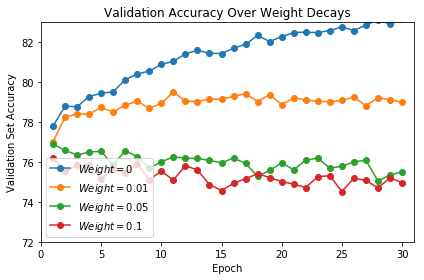

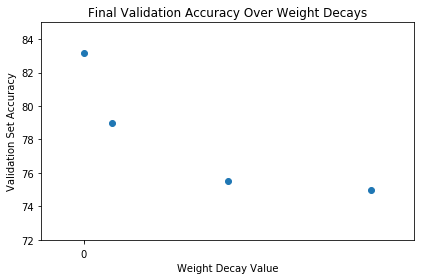

In [91]:
val_acc = np.asarray(val_acc)
for xdat, ydat, wd in zip(xdata, val_acc, WD):
    plt.plot(xdat, ydat, marker='o', linestyle='-', label=r'$Weight = {0}$'.format(wd))
    
plt.title('Validation Accuracy Over Weight Decays')
plt.xlabel('Epoch')
plt.ylabel('Validation Set Accuracy')
plt.xlim([0, num_epochs+1])
plt.ylim([72, 83])
plt.legend(loc=3)
plt.tight_layout()
plt.show()

plt.scatter(WD, val_acc[:,-1])
plt.title('Final Validation Accuracy Over Weight Decays')
plt.xlabel('Weight Decay Value')
plt.ylabel('Validation Set Accuracy')
plt.ylim([72, 85])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Training for different values of lambda:
Based on the plots of validation set accuracy as a function of regularization parameter, we can see that we should likely stop training on a model once the accuracy on the validation set stops increasing and begins to decrease. Once the accuracy on the validation set ceases to increase, it means that our model with the current hyperparameters is saturated, and more training might result in overfitting. 

### Testing the best regularization parameter

In [92]:
# Best index from weight decay assessment
best_idx = 2

# test the model corresponding to this index:
model_best = model[best_idx]
correct_ts = 0
total_ts = 0
for data in testloader:
    images, labels = data
    outputs = model_best(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total_ts += labels.size(0)
    correct_ts += (predicted == labels).sum()

# Print output
print('Accuracy of the network on the %d test images: %d' % (total_ts ,100 * correct_ts / total_ts))

Accuracy of the network on the 10000 test images: 77


## Problem 3: Multi-Layer Perceptron

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import torch.utils.data
import caffeine

# Multi Layer Perceptron Model:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(MLP, self).__init__()
        
        # Define initial layer
        self.fc_initial = nn.Linear(input_dim, hidden_dim)
        
        # Initialize layer
        torch.nn.init.xavier_uniform(self.fc_initial.weight)
        torch.nn.init.constant(self.fc_initial.bias, 0.0)
        
        # Hidden layers
        self.fc_mid = nn.ModuleList()
        self.additional_hidden_wide = additional_hidden_wide
        for i in range(self.additional_hidden_wide):
            # Define hidden layers
            self.fc_mid.append(nn.Linear(hidden_dim, hidden_dim))
            # Initialze hidden layers
            torch.nn.init.xavier_uniform(self.fc_mid[i].weight)
            torch.nn.init.constant(self.fc_mid[i].bias, 0.0)
        
        # Define output layers
        self.fc_final = nn.Linear(hidden_dim, output_dim)
        
        # Define nonlinearity
        self.nonlinearity = nonlinearity

    def forward(self, x):
        # Reshape the size of the variables
        x = x.view(x.size(0), -1)
        x = self.fc_initial(x)
        x = self.nonlinearity(x)
        for i in range(self.additional_hidden_wide):
            x = self.fc_mid[i](x)
            x = self.nonlinearity(x)
        x = self.fc_final(x)
        return x

In [89]:
def test_MLP(trainloader, validloader, lr=1e-1, epochs=30, wd=1e-2, hidden_dim=25, batch=256):
    valid_num = 10000
    trainloader, validloader, testloader, imsize = load_MNIST(batch=batch, valid_num=valid_num)
    num_classes = 10
    input_dim = imsize*imsize
    correct_vs = np.zeros(epochs)
    total_vs = np.zeros(epochs)
    x_epoch = []
    y_valacc = []
    accum=[]

    # Initialize the model
    model2 = MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, 
                 nonlinearity=fn.tanh, additional_hidden_wide=1)
    print(model2)

    # Set up loss and optimization
    criterion = nn.CrossEntropyLoss(size_average=True)
    optimizer = torch.optim.SGD(model2.parameters(), lr = lr ,weight_decay=wd)

    # Train over the model
    for epoch in tnrange(epochs):
        localaccum = []        
        for i, dataTRAIN in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = dataTRAIN

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)        

            # Evaluate performance on model
            output = model2.forward(inputs)
            loss = criterion(output, labels)

            # Back propagate
            model2.zero_grad()
            loss.backward()
            optimizer.step()

            # Append loss stats
            localaccum.append(loss.data[0])

        # Test on validation set:
        for i2, dataVAL in enumerate(validloader, 0):
            images, labels = dataVAL
            outputs = model2(Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total_vs[epoch] += labels.size(0)
            correct_vs[epoch] += (predicted == labels).sum()

        # Store validation results
        val_acc = 100 * correct_vs[epoch] / total_vs[epoch]
        if epoch % 5 == epoch-1:
            print('Validation Accuracy: %.2f' % val_acc)
        x_epoch.append(epoch+1)
        y_valacc.append(val_acc)
        accum.append(np.mean(localaccum))
    
    # Returns:
    return (model2, testloader, accum, x_epoch, y_valacc)

In [90]:
batch = 256
lr = 1e-1
wd = 1e-2
epochs = 10
hidden_dim = 25

In [91]:
model_MLP, testloader, loss, x_epoch, y_valacc = test_MLP(trainloader, validloader, lr=lr, epochs=epochs, 
                                              wd=wd, hidden_dim=hidden_dim, batch=batch)

MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

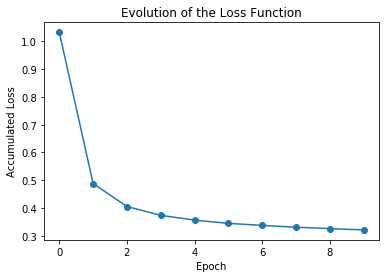

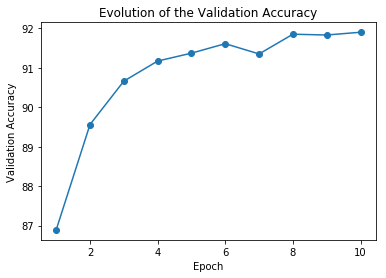

In [92]:
# Plot accumulated loss of each epoch
plt.plot(loss, marker='o');
plt.xlabel('Epoch')
plt.ylabel('Accumulated Loss')
plt.title('Evolution of the Loss Function')
plt.show()

# Plot validation accuracy  of each epoch
plt.plot(x_epoch, y_valacc, marker='o');
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Evolution of the Validation Accuracy')
plt.show()

In [102]:
# Evaluate model on test sets
correct_ts = 0
total_ts = 0

for data in testloader:
    images, labels = data
    outputs = model_MLP(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total_ts += labels.size(0)
    correct_ts += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d' % (100 * correct_ts / total_ts))

Accuracy of the network on the test images: 92


## Making a `scikit-learn` like interface

Since we want to run many experiments, we'll go ahead and wrap our fitting process in a sklearn style interface.

In [153]:
from tqdm import tnrange, tqdm_notebook
class MLPClassifier:
    
    def __init__(self, input_dim, hidden_dim=10, 
                 output_dim = 10, nonlinearity = fn.tanh, 
                 additional_hidden_wide=0, lr=0.1, epochs=50, batch_size=64, wd=0):

        self._pytorch_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity, additional_hidden_wide)
        self._criterion = nn.CrossEntropyLoss(size_average=True)
        self._fit_params = dict(lr=lr, epochs=epochs, batch_size=batch_size, wd=wd)
        self._optim = torch.optim.SGD(self._pytorch_model.parameters(), lr = self._fit_params['lr'] )
        
    def __repr__(self):
        num=0
        for k, p in self._pytorch_model.named_parameters():
            numlist = list(p.data.numpy().shape)
            if len(numlist)==2:
                num += numlist[0]*numlist[1]
            else:
                num+= numlist[0]
        return repr(self._pytorch_model)+"\n"+repr(self._fit_params)+"\nNum Params: {}".format(num)
    
    def set_fit_params(self, *, lr=0.1, epochs=50, batch_size=64, wd=0):
        self._fit_params['batch_size'] = batch_size
        self._fit_params['epochs'] = epochs
        self._fit_params['lr'] = lr
        self._fit_params['wd'] = wd
        
    
    def fit(self, trainloader):
        """
        Runs the fitting of the model over each of the epochs.
        """
        # Initialize optimizer
        self._optim = torch.optim.SGD(self._pytorch_model.parameters(), lr = self._fit_params['lr'] )
        
        self._accum=[]
        for epoch in tnrange(self._fit_params['epochs']):
            localaccum = []        
            for i, dataTRAIN in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = dataTRAIN
                
                # wrap them in Variable
                inputs, labels = Variable(inputs), Variable(labels)        

                # Evaluate performance on model
                output = self._pytorch_model.forward(inputs)
                loss = self._criterion(output, labels)

                # Back propagate
                self._pytorch_model.zero_grad()
                loss.backward()
                self._optim.step()

                # Append loss stats
                localaccum.append(loss.data[0])
            self._accum.append(np.mean(localaccum))

    def plot_loss(self):
        plt.figure(figsize=(8,6))       
        plt.plot(self._accum, label="{}".format(self))
        plt.legend()
        plt.show()
        
    def predict(self, testloader):
        # Evaluate model on test sets
        correct_ts = 0
        total_ts = 0

        for data in testloader:
            images, labels = data
            outputs = model_MLP(Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total_ts += labels.size(0)
            correct_ts += (predicted == labels).sum()

        return correct_ts/total_ts

In [143]:
# One working example:
num_classes=10
epochs=5
wd=1e-2
batch_size=256
clf = MLPClassifier(input_dim=imsize*imsize, hidden_dim=hidden_dim, output_dim=num_classes,
                    nonlinearity=fn.tanh, additional_hidden_wide=1, epochs=epochs, wd=wd, batch_size=batch_size)

print(clf)

trainloader, _, testloader, _ = load_MNIST(batch=batch, valid_num=0)

clf.fit(trainloader)

MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)
{'lr': 0.1, 'epochs': 5, 'batch_size': 256, 'wd': 0.01}
Num Params: 20535


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

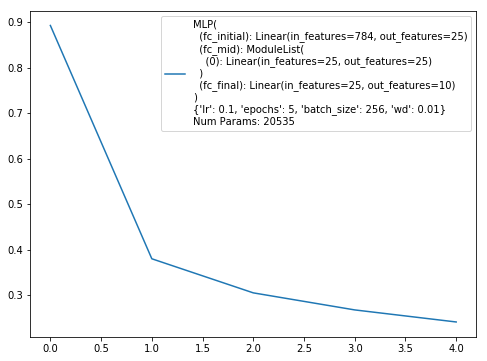

In [144]:
clf.plot_loss()

In [145]:
accuracy = clf.predict(testloader)
print('Accuracy:', accuracy)

Accuracy: 0.9244


## Now try to optimize over a grid space of parameters:

In [209]:
# Set up parameters
lrs = [0.1, 0.05, 0.01]
#batch_sizes = [20, 50, 100, 200]
batch_sizes = 100
hidden_dims = [25, 50]
#hidden_dims = [25, 50, 75, 100]

# Make my own grid search:
lr_grid, batch_grid, hidden_dim_grid = np.meshgrid(lrs, batch_sizes, hidden_dims)
accuracy = np.zeros(lr_grid.size)

In [226]:
# Run model over grid parameters
for i, lr, batch_size, hidden_dim in zip(tnrange(lr_grid.size), lr_grid.ravel(), batch_grid.ravel(), hidden_dim_grid.ravel()):

    # Initialize model with parameters and do a mini train
    model = MLPClassifier(input_dim=imsize*imsize, epochs = 5, batch_size=batch_size, lr=lr, 
                          hidden_dim=int(hidden_dim), additional_hidden_wide=1)

    # Load data
    trainloader, validloader, testloader, _ = load_MNIST(batch=batch_size, valid_num=10000)
    
    print(model)

    # Fit data
    model.fit(trainloader)
    
    # Test on validation set
    accuracy[i] = model.predict(validloader)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))



MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)
{'lr': 0.10000000000000001, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 20535


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Exception in thread Thread-53:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



MLP(
  (fc_initial): Linear(in_features=784, out_features=50)
  (fc_mid): ModuleList(
    (0): Linear(in_features=50, out_features=50)
  )
  (fc_final): Linear(in_features=50, out_features=10)
)
{'lr': 0.10000000000000001, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 42310


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)
{'lr': 0.050000000000000003, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 20535


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

MLP(
  (fc_initial): Linear(in_features=784, out_features=50)
  (fc_mid): ModuleList(
    (0): Linear(in_features=50, out_features=50)
  )
  (fc_final): Linear(in_features=50, out_features=10)
)
{'lr': 0.050000000000000003, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 42310


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)
{'lr': 0.01, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 20535


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

MLP(
  (fc_initial): Linear(in_features=784, out_features=50)
  (fc_mid): ModuleList(
    (0): Linear(in_features=50, out_features=50)
  )
  (fc_final): Linear(in_features=50, out_features=10)
)
{'lr': 0.01, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 42310


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [225]:
# Find the best accuracy and take the parameters 
idxmax = np.argmax(accuracy)
lr_best = lr_grid.ravel()[idxmax]
batch_best = batch_grid.ravel()[idxmax]
hidden_best = hidden_dim_grid.ravel()[idxmax]

# Do a full training on this model
# Initialize model with parameters and do a mini train
model = MLPClassifier(input_dim=imsize*imsize, epochs = 10, batch_size=batch_best, lr=lr_best, 
                          hidden_dim=int(hidden_best), additional_hidden_wide=1)
# Load data
trainloader, validloader, testloader, _ = load_MNIST(batch=batch_best, valid_num=0)

# Fit data
model.fit(trainloader)

# Test on test set
accuracy_overall = model.predict(testloader)

MLP(
  (fc_initial): Linear(in_features=784, out_features=25)
  (fc_mid): ModuleList(
    (0): Linear(in_features=25, out_features=25)
  )
  (fc_final): Linear(in_features=25, out_features=10)
)
{'lr': 0.10000000000000001, 'epochs': 10, 'batch_size': 100, 'wd': 0}
Num Params: 20535


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x12DD20908>>
Process Process-798:
  File "/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 585, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt
  File "/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torch

KeyboardInterrupt: 

In [224]:
print(accuracy)
print(accuracy_overall)

[ 0.919  0.919  0.919  0.919  0.919  0.919]
0.9244
MLP(
  (fc_initial): Linear(in_features=784, out_features=50)
  (fc_mid): ModuleList(
    (0): Linear(in_features=50, out_features=50)
  )
  (fc_final): Linear(in_features=50, out_features=10)
)
{'lr': 0.01, 'epochs': 5, 'batch_size': 100, 'wd': 0}
Num Params: 42310
